# Import Libraries


In [1]:
import pandas as pd
import numpy as np
import os
import nltk
import tensorflow as tf
from keras.layers import *
from tensorflow import *
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import *
from nltk.tokenize import word_tokenize, sent_tokenize
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import  CountVectorizer
from sklearn.preprocessing import LabelEncoder
import warnings
import csv
import random
from collections import Counter
from source.textnormalization import TextNormalization
from source.machinelearning import machine_learning_model, fit_model, metrics_values, confusion_matrix_
from source.deeplearning import convolutional_neural_network_1d, model_compile, model_fit, evaluate, plot_accuracy_loss, lstm_
from source.sentimentinformation import sentiment_percentage, sentiment_counts
from source.wordcloud import wordcloud
from source.most_frequent_word_plot import go_figure, bar_plot
pd.options.display.max_rows = 100
pd.options.display.max_columns =None 
import arabic_reshaper
from bidi.algorithm import get_display
random.seed(40)
tf.random.set_seed(40)

# Download Some Packages

In [2]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/osamaanmar/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/osamaanmar/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/osamaanmar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/osamaanmar/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

# Ignore Warnings

In [3]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
warnings.filterwarnings(action='ignore')

# Read Data

In [4]:
df1 = pd.read_csv('dev.csv')
df2 = pd.read_csv('train.csv')
df3 = pd.read_csv('test.csv')
Corpus = pd.concat([df1, df2, df3], ignore_index=True)
Corpus.drop('clean_txt', inplace=True, axis=1)
Corpus.rename(columns={'sentiment': 'Sentiment', 'txt': 'Text'}, inplace=True)
Corpus.tail(5)

,Sentiment,Text
16434,Negative,بين الشفقة و العطف أقيم هذه الرواية يؤسفني جد...
16435,Negative,"أوصيك بالدقة . لا بالوضوح . "" فاليري"" تقريباً..."
16436,Negative,للاسف الشديد لم يعجبني الكتاب ، شعرت بالملل م...
16437,Positive,من بداية الرواية وانا احاول تمالك نفسي ولكن ت...
16438,Negative,خذلتنى هذه الرواية كثيرا لم يعجبنى ابدا تداخل...


# Sentiment Information

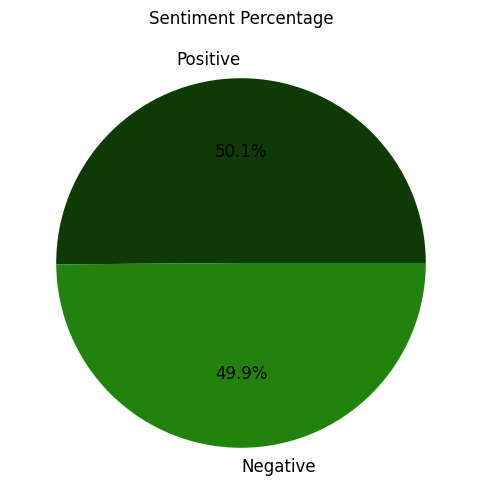

In [5]:
sentiment_percentage(Corpus, 'Sentiment', (6, 6))

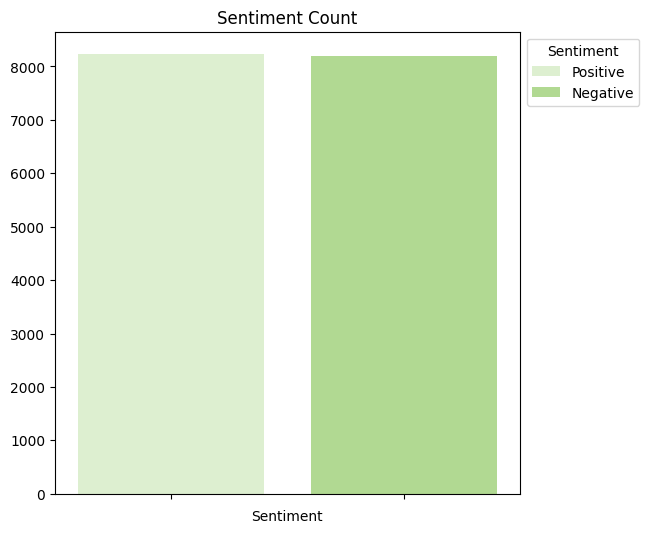

In [6]:
sentiment_counts(Corpus, 'Sentiment', (6, 6))

# Number Of Sentences

In [7]:
Corpus['NumberOfSentences'] = Corpus['Text'].apply(lambda n:len(sent_tokenize(n)))
Corpus.drop(Corpus[Corpus["NumberOfSentences"] == 0].index, inplace = True)


In [8]:
Corpus['NumberOfSentences'].sum()

48524

# Average Number Of Sentences

In [9]:
AverageNumberOfSentence = int(np.round(Corpus["NumberOfSentences"].mean()))
AverageNumberOfSentence

3

# Maximum Number Of Sentences

In [10]:
MaximumNumberOfSentence = Corpus["NumberOfSentences"].max()
MaximumNumberOfSentence

326

# Minimum Number Of Sentences

In [11]:
MinimumNumberOfSentence = Corpus["NumberOfSentences"].min()
MinimumNumberOfSentence

1

# Text Normalization

In [12]:
text_normalization = TextNormalization(_remove_emojis = True,
                                        _remove_hashtags = False,
                                        _remove_emails = False ,
                                        _remove_url = False,
                                        _remove_mention = False,
                                        _remove_duplicate_char = True,
                                        _remove_single_char = True,
                                        _remove_special_character_ = True,
                                        _remove_new_line_char = True,
                                        _remove_number = True,
                                        _remove_html_tags = True,
                                        _remove_arabic_diacritics_ = True,
                                        _normalize_arabic_unicode_ = True,
                                        _normalize_alef_maksura_ar_ = True,
                                        _normalize_alef_ar_ = True,
                                        _normalize_teh_marbuta_ar_ = True,
                                        _remove_non_arabic = True,
                                        _remove_whitespace_ = True,
                                        _remove_unicode_characters_ = True,
                                        _remove_longest_than_ = True,
                                        _remove_stop_words = True,
                                        _lemmatizer_ = False,
                                        _stemmer_ = False)

In [13]:
Corpus['Normalized_Text'] = Corpus['Text'].apply(lambda x: text_normalization.normalization(x))
Corpus

,Sentiment,Text,NumberOfSentences,Normalized_Text
0,Positive,بالنسبالي دي احسن رواية كتبها احمد مراد,1,بالنسبالي دي احسن روايه كتبها احمد مراد
1,Negative,الرواية ممتعة (كأحداث) ولكن يعيبها ما يلي : 1-...,3,الروايه ممتعه كاحداث يعيبها الاسلوب يستخدم الف...
2,Positive,كتآب أنيق ف حسب .,1,كتاب انيق
3,Negative,مش مقتنعه بصراحه بالجو بتاعه ده:),1,مش مقتنعه بصراحه بالجو بتاعه ده
4,Negative,قرأت 100 ورقة ووقفت . كلام تقيل جدًا ومش فاهمه...,2,قرات ورقه ووقفت كلام تقيل جدا ومش فاهمه مش قاد...
...,...,...,...,...
16434,Negative,بين الشفقة و العطف أقيم هذه الرواية يؤسفني جد...,1,الشفقه العطف اقيم الروايه يؤسفني معاناه محمد ش...
16435,Negative,"أوصيك بالدقة . لا بالوضوح . "" فاليري"" تقريباً...",3,اوصيك بالدقه بالوضوح فاليري ابراهيم اصلان نفذ ...
16436,Negative,للاسف الشديد لم يعجبني الكتاب ، شعرت بالملل م...,2,للاسف الشديد يعجبني الكتاب شعرت بالملل الصفحات...
16437,Positive,من بداية الرواية وانا احاول تمالك نفسي ولكن ت...,14,بدايه الروايه وانا احاول تمالك تعاندني عبرات م...


# Number Of Unique Words

In [14]:
UniqueWords = set()
for word in Corpus['Normalized_Text'].str.split():
    UniqueWords.update(word)

len(UniqueWords)

74034

# WordCloud

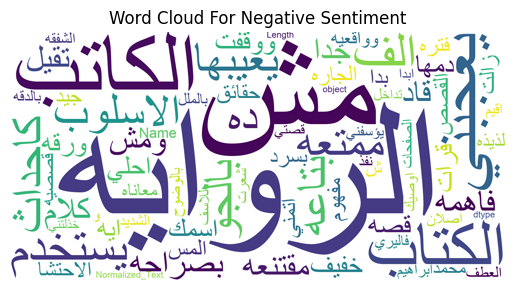

In [15]:
wordcloud(data=Corpus, target='Negative', width=2000, hieght=1000, text='Normalized_Text')

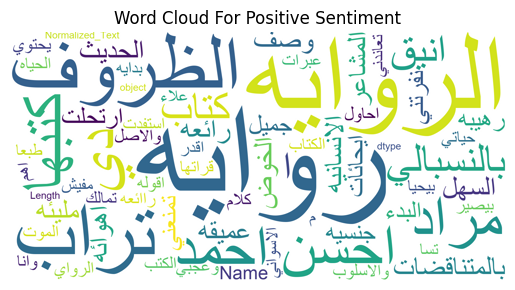

In [16]:
wordcloud(data=Corpus, target='Positive', width=2000, hieght=1000, text='Normalized_Text')

# Most Frequent Words 

In [17]:
MostFrequentWord = Counter((Corpus['Normalized_Text']).str.split().explode()).most_common(15)
MostFrequentWordDF = pd.DataFrame(MostFrequentWord, columns=('Word', 'Count'))
MostFrequentWordDF

,Word,Count
0,الروايه,7347
1,الكتاب,6617
2,كتاب,3828
3,روايه,3154
4,الكاتب,2793
5,الله,2312
6,اللي,1878
7,مش,1444
8,رائع,1431
9,الاحداث,1247


In [18]:
go_figure(data=MostFrequentWordDF)

In [19]:
bar_plot(data=MostFrequentWordDF)

# Number Of Words 

In [20]:
Corpus["Number of Words"] = Corpus["Normalized_Text"].apply(lambda n:len(word_tokenize(n)))
Corpus.drop(Corpus[ Corpus["Number of Words"] == 0].index, inplace = True)
Corpus["Number of Words"].sum()

569184

# Number Of Charachters 

In [21]:
Corpus["Number of Charachters"] = Corpus["Normalized_Text"].str.len()
Corpus["Number of Charachters"].sum()

3543446

# Average Number Of Words 

In [22]:
AverageNaumberOfWords = int(np.round((Corpus["Number of Words"].mean())))
AverageNaumberOfWords

35

# Average Number Of Charachters 

In [23]:
AverageNumberOfCharachters = int(np.round(Corpus["Number of Charachters"].mean()))
AverageNumberOfCharachters

216

# Maximum Number Of Word

In [24]:
MaximumNaumberOfWords = Corpus["Number of Words"].max()
MaximumNaumberOfWords

1853

# Maximum Number Of Charachters 

In [25]:
MaximumNumberOfCharachters = Corpus['Number of Charachters'].max() 
MaximumNumberOfCharachters

11593

# Minimum Number Of Words

In [26]:
MimimumNaumberOfWords = Corpus["Number of Words"].min()
MimimumNaumberOfWords

1

# Minimum Number Of Charachters 

In [27]:
MinimumNumberOfCharachters = Corpus['Number of Charachters'].min() 
MinimumNumberOfCharachters

3

# Split The Dataset Into X And y

In [28]:
X, y = Corpus['Normalized_Text'], Corpus['Sentiment']
le = LabelEncoder()
y =le.fit_transform(y)

# Split The Dataset Into Training And Testing

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=44)

# CountVectorizer

In [30]:
CountVectorizer_ = CountVectorizer()
X_train_CV_ = CountVectorizer_.fit_transform(X_train)
X_test_CV_ = CountVectorizer_.transform(X_test)

In [31]:
Vocabulary = CountVectorizer_.vocabulary_
Vocabulary

{'سيناريو': 30772,
 'فيلم': 35960,
 'عربي': 33000,
 'ساذج': 29583,
 'فشل': 35146,
 'روايه': 29154,
 'مثيره': 44379,
 'استمتعت': 2533,
 'جيد': 26175,
 'قراءه': 36337,
 'الروايه': 8265,
 'اكره': 4350,
 'البطل': 5895,
 'جاء': 25442,
 'التقييم': 6584,
 'درااما': 27927,
 'ملهاش': 46924,
 'اي': 15373,
 'لازمه': 38398,
 'تعجبني': 23588,
 'ابدا': 141,
 'كتبت': 37242,
 'طريقه': 32284,
 'الخواطر': 7732,
 'غازي': 33689,
 'القصيبي': 10712,
 'اجتر': 790,
 'طوال': 32387,
 'القصه': 10707,
 'مليئه': 46950,
 'بالمعاناه': 17159,
 'والماساه': 52883,
 'يوجد': 63935,
 'احداث': 1084,
 'تشد': 23064,
 'انتباه': 14482,
 'القارئ': 10538,
 'مجرد': 44459,
 'مذكرات': 45036,
 'لمصاب': 42171,
 'بالزهايمر': 16623,
 'اسوا': 2803,
 'قرات': 36356,
 'لغازي': 40318,
 'الاسف': 4934,
 'حاولت': 26331,
 'اتحشي': 365,
 'الكتاب': 10896,
 'لشعوري': 40046,
 'بسيط': 18907,
 'اضطررت': 3185,
 'لقراءته': 40489,
 'بناء': 20167,
 'طلب': 32345,
 'البوك': 6003,
 'كلاب': 37666,
 'اللي': 11234,
 'مشتركه': 45690,
 'كتاب': 37209,
 'خفيف': 27

# Machine Learning

**1-Naive Bayes**

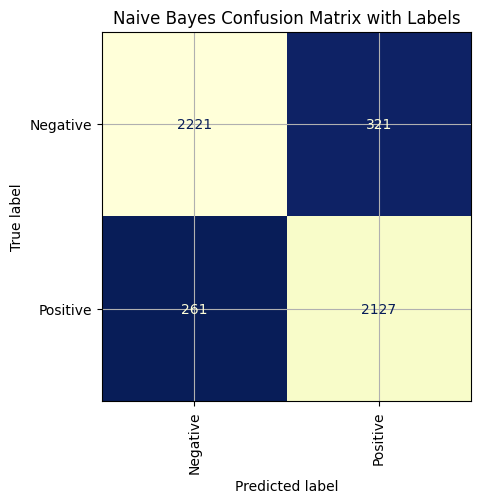

In [32]:
Algorithm = MultinomialNB(alpha= 1)
Naive_Bayes = machine_learning_model(algorithm=Algorithm)
fit_model(model=Naive_Bayes, X_train=X_train_CV_, y_train=y_train)
confusion_matrix_(model=Naive_Bayes, X_test=X_test_CV_, y_test=y_test, name='Naive Bayes')

In [33]:
metrics_values(model= Naive_Bayes, X_test=X_test_CV_, y_test=y_test)

,Values
Accuracy,0.881947
Precision,0.890704
Recall,0.868873
F1Score,0.879653
Error,0.118053


**2-Logistic Regression**

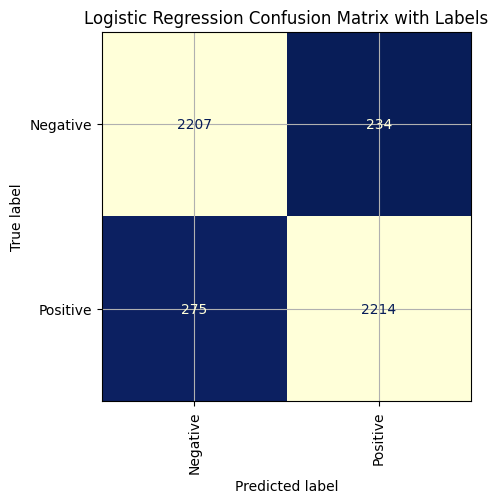

In [34]:
Algorithm = LogisticRegression()
Logistic_Regression = machine_learning_model(algorithm=Algorithm)
fit_model(model=Logistic_Regression, X_train=X_train_CV_, y_train=y_train)
confusion_matrix_(Logistic_Regression, X_test=X_test_CV_, y_test=y_test, name='Logistic Regression')

In [35]:
metrics_values(model= Logistic_Regression, X_test=X_test_CV_, y_test=y_test)

,Values
Accuracy,0.896755
Precision,0.889514
Recall,0.904412
F1Score,0.896901
Error,0.103245


**3-Decision Tree**

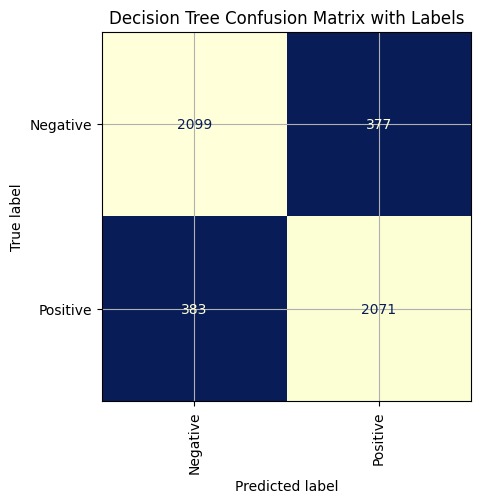

In [36]:
Algorithm = DecisionTreeClassifier(criterion='entropy')
Decision_Tree = machine_learning_model(algorithm=Algorithm)
fit_model(model=Decision_Tree, X_train=X_train_CV_, y_train=y_train)
confusion_matrix_(model=Decision_Tree, X_test=X_test_CV_, y_test=y_test, name='Decision Tree')

In [37]:
metrics_values(model= Decision_Tree, X_test=X_test_CV_, y_test=y_test)

,Values
Accuracy,0.845842
Precision,0.843928
Recall,0.845997
F1Score,0.844961
Error,0.154158


**4-K Nearest Neighbors**

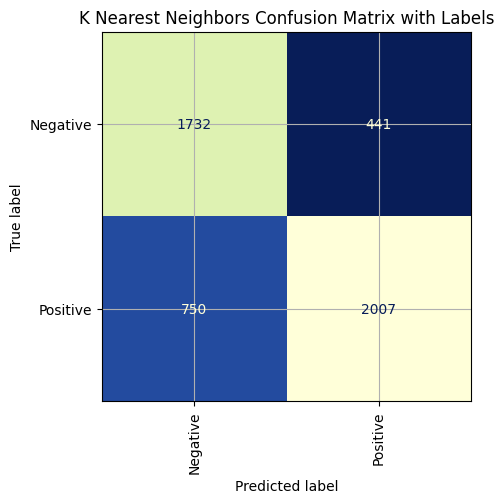

In [38]:
Algorithm =KNeighborsClassifier(metric='cosine', n_neighbors=5)
K_Nearest_Neighbors = machine_learning_model(algorithm=Algorithm)
fit_model(model=K_Nearest_Neighbors, X_train=X_train_CV_, y_train=y_train)
confusion_matrix_(model=K_Nearest_Neighbors, X_test=X_test_CV_, y_test=y_test, name='K Nearest Neighbors')

In [39]:
metrics_values(model= K_Nearest_Neighbors, X_test=X_test_CV_, y_test=y_test)

,Values
Accuracy,0.758418
Precision,0.727965
Recall,0.819853
F1Score,0.771182
Error,0.241582


**5-Random Forest**

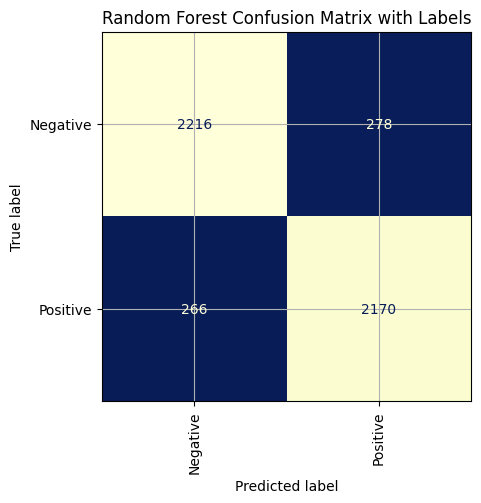

In [40]:
Algorithm = RandomForestClassifier(criterion = 'entropy', n_estimators=100)
Random_Forest = machine_learning_model(algorithm=Algorithm)
fit_model(model=Random_Forest, X_train=X_train_CV_, y_train=y_train)
confusion_matrix_(model=Random_Forest, X_test=X_test_CV_, y_test=y_test, name='Random Forest')

In [41]:
metrics_values(model= Random_Forest, X_test=X_test_CV_, y_test=y_test)

,Values
Accuracy,0.889655
Precision,0.890805
Recall,0.886438
F1Score,0.888616
Error,0.110345


**6-SGD Classifier**

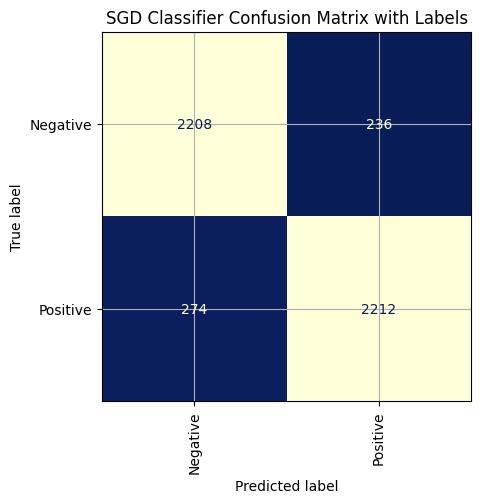

In [42]:
Algorithm = SGDClassifier(loss='hinge')
SGD = machine_learning_model(algorithm=Algorithm)
fit_model(model=SGD, X_train=X_train_CV_, y_train=y_train)
confusion_matrix_(model=SGD, X_test=X_test_CV_, y_test=y_test, name='SGD Classifier')

In [43]:
metrics_values(model= SGD, X_test=X_test_CV_, y_test=y_test)

,Values
Accuracy,0.896552
Precision,0.889783
Recall,0.903595
F1Score,0.896636
Error,0.103448


**7-Multilayer Perceptron**

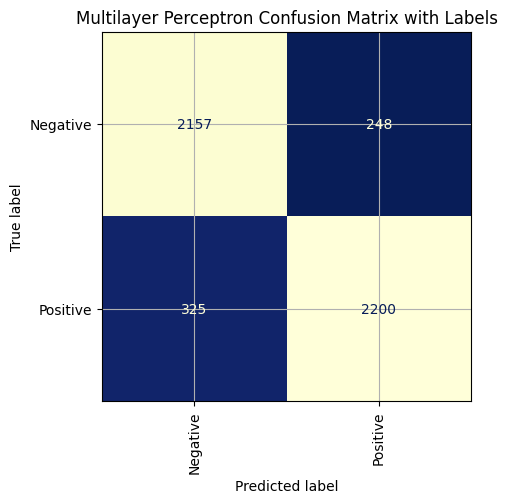

In [44]:
Algorithm = MLPClassifier(hidden_layer_sizes=16)
MLP = machine_learning_model(algorithm=Algorithm)
fit_model(model=MLP, X_train=X_train_CV_, y_train=y_train)
confusion_matrix_(model=MLP, X_test=X_test_CV_, y_test=y_test, name='Multilayer Perceptron')

In [45]:
metrics_values(model= MLP, X_test=X_test_CV_, y_test=y_test)

,Values
Accuracy,0.883773
Precision,0.871287
Recall,0.898693
F1Score,0.884778
Error,0.116227


# Deep Learning

In [46]:
tokenizer = Tokenizer(oov_token='<oov>')
tokenizer.fit_on_texts(X)
embedding_dim = 16
vocab_size = len(tokenizer.word_index) + 1
vocab_size

74036

In [47]:
X_train_seqs = tokenizer.texts_to_sequences(X_train)
X_test_seqs = tokenizer.texts_to_sequences(X_test)
max_length =  max([len(x) for x in X_train_seqs])
max_length

1853

In [48]:
encoded_X_train = pad_sequences(X_train_seqs, maxlen=max_length)
encoded_X_test = pad_sequences(X_test_seqs, maxlen=max_length)

In [49]:
Callback = tf.keras.callbacks.EarlyStopping(
                    monitor="accuracy",
                    mode="max",
                    patience=0
                )

**8-Convolutional Neural Network**

Epoch 1/50
719/719 [==============================] - 219s 296ms/step - loss: 0.6828 - accuracy: 0.5813 - val_loss: 0.6546 - val_accuracy: 0.7150
Epoch 2/50
719/719 [==============================] - 139s 193ms/step - loss: 0.5300 - accuracy: 0.7969 - val_loss: 0.4640 - val_accuracy: 0.8320
Epoch 3/50
719/719 [==============================] - 98s 137ms/step - loss: 0.3228 - accuracy: 0.8955 - val_loss: 0.3541 - val_accuracy: 0.8651
Epoch 4/50
719/719 [==============================] - 50s 69ms/step - loss: 0.2251 - accuracy: 0.9294 - val_loss: 0.3207 - val_accuracy: 0.8736
Epoch 5/50
719/719 [==============================] - 40s 56ms/step - loss: 0.1699 - accuracy: 0.9507 - val_loss: 0.3092 - val_accuracy: 0.8813
Epoch 6/50
719/719 [==============================] - 36s 50ms/step - loss: 0.1340 - accuracy: 0.9624 - val_loss: 0.3104 - val_accuracy: 0.8864
Epoch 7/50
719/719 [==============================] - 42s 58ms/step - loss: 0.1087 - accuracy: 0.9711 - val_loss: 0.3211 - val_accu

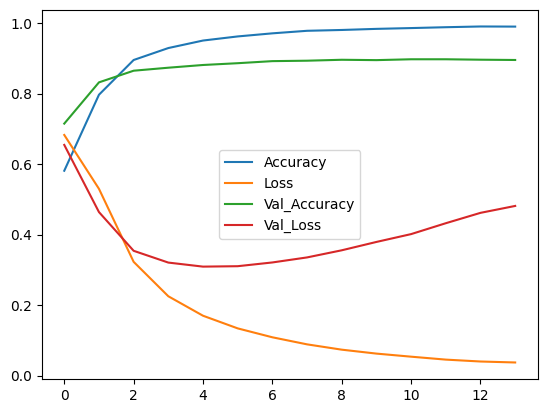

 
The Training Loss is 0.0336, And Training Accuracy is 0.9922
 
The Testing Loss is 0.4814, And Testing Accuracy is 0.8955


In [50]:
convolutional_neural_network = convolutional_neural_network_1d(vocab_size=vocab_size, embedding_dim=embedding_dim, max_length=max_length, dropout=0.3, kernel=8, filters=32)
model_compile(model=convolutional_neural_network)
history = model_fit(model=convolutional_neural_network, X_train=encoded_X_train, y_train=y_train, epochs=50, X_test=encoded_X_test, y_test=y_test, batch_size=16, Callback=Callback)
plot_accuracy_loss(histoty=history)
evaluate(model=convolutional_neural_network, x=encoded_X_train, y=y_train, train_test='Training')
evaluate(model=convolutional_neural_network, x=encoded_X_test, y=y_test, train_test='Testing')

**9-LSTM**

Epoch 1/10
360/360 [==============================] - 183s 469ms/step - loss: 0.6015 - accuracy: 0.6925 - val_loss: 0.4087 - val_accuracy: 0.8312
Epoch 2/10
360/360 [==============================] - 136s 377ms/step - loss: 0.2048 - accuracy: 0.9285 - val_loss: 0.2877 - val_accuracy: 0.8848
Epoch 3/10
360/360 [==============================] - 122s 338ms/step - loss: 0.0704 - accuracy: 0.9773 - val_loss: 0.3363 - val_accuracy: 0.8951
Epoch 4/10
360/360 [==============================] - 117s 326ms/step - loss: 0.0303 - accuracy: 0.9909 - val_loss: 0.3930 - val_accuracy: 0.8890
Epoch 5/10
360/360 [==============================] - 115s 319ms/step - loss: 0.0165 - accuracy: 0.9951 - val_loss: 0.4679 - val_accuracy: 0.8343
Epoch 6/10
360/360 [==============================] - 110s 305ms/step - loss: 0.0236 - accuracy: 0.9938 - val_loss: 0.4187 - val_accuracy: 0.8856


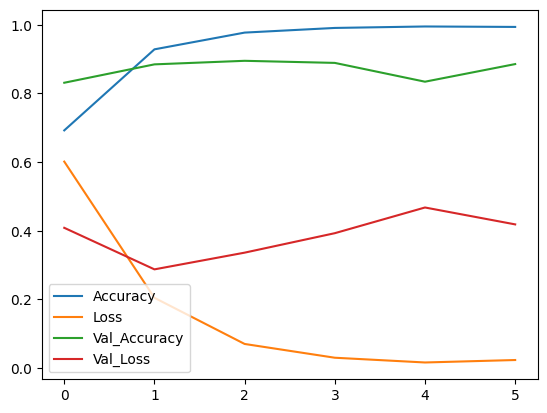

 
The Training Loss is 0.0093, And Training Accuracy is 0.9977
 
The Testing Loss is 0.4187, And Testing Accuracy is 0.8856


In [51]:
LSTM = lstm_(vocab_size= vocab_size, embedding_dim= embedding_dim, max_length= max_length, dropout=0.2, units=64)
model_compile(model=LSTM)
history = model_fit(model=LSTM, X_train=encoded_X_train, y_train=y_train, epochs=10, X_test=encoded_X_test, y_test=y_test, batch_size=32, Callback=Callback)
plot_accuracy_loss(histoty=history)
evaluate(model=LSTM, x=encoded_X_train, y=y_train, train_test='Training')
evaluate(model=LSTM, x=encoded_X_test,y= y_test, train_test='Testing')